In [207]:
from sklearn.gaussian_process.kernels import RBF
from numpy.linalg import inv, cholesky
from numpy import inner, identity
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.special import kv


In [192]:
# 훈련 데이터와 테스트 데이터 정의
X_train = np.array([0.2, 0.4, 0.5, 0.6, 0.8, 1.0]).reshape(-1, 1)
y_train = np.array([np.sin(-4.8*x) + 0.8*np.random.rand() + 1 for x in X_train]).reshape(-1, 1)
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

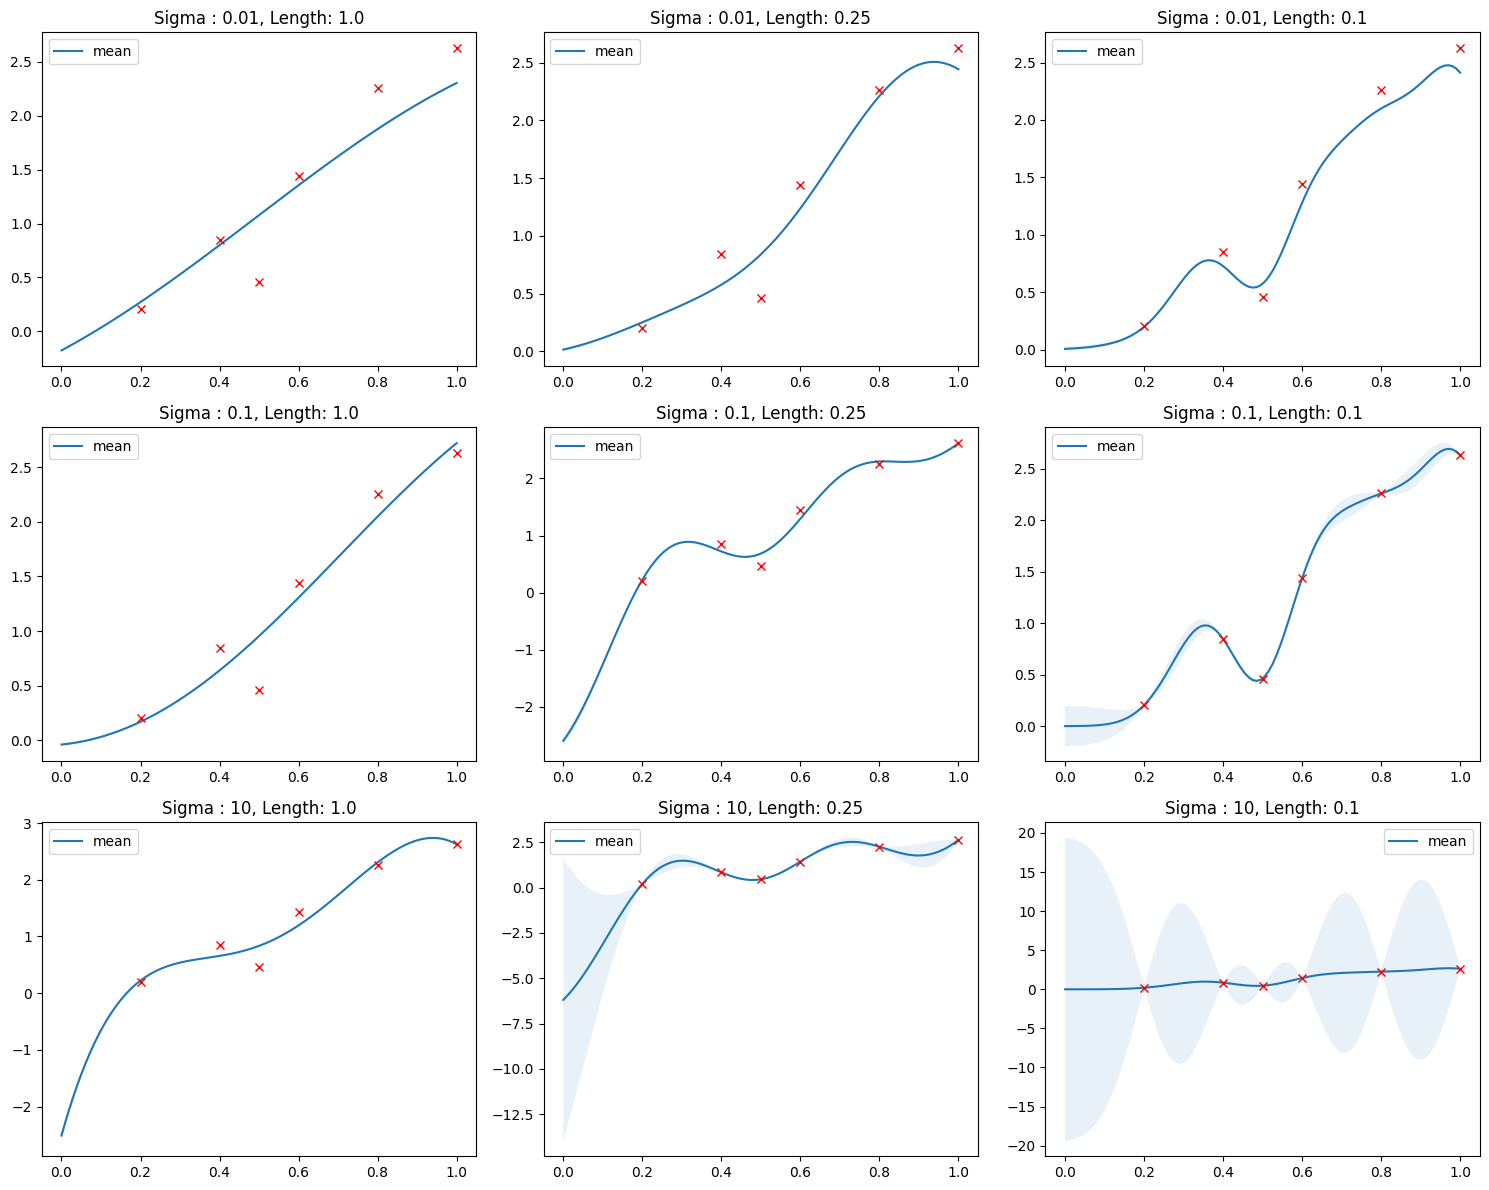

In [206]:
# 훈련 데이터와 테스트 데이터 정의
X_train = np.array([0.2, 0.4, 0.5, 0.6, 0.8, 1.0]).reshape(-1, 1)
y_train = np.array([np.sin(-4.8*x) + 0.8*np.random.rand() + 1 for x in X_train]).reshape(-1, 1)
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# RBF 커널 함수 정의
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """RBF 커널 (가우시안 커널) 계산"""
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# 다양한 length scale 값에 대한 예측을 시각화하는 함수
def plot_gp(mu, cov, X, X_train=None, y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, y_train, 'rx')
    plt.legend()

# 여러 length scale에 대해 GPR을 수행하고 결과를 시각화
length_scales = [1.0, 0.25, 0.1]
alpha = [0.01,0.1,10]

# 전체 플롯을 위한 figure 생성
fig, axs = plt.subplots(len(alpha), len(length_scales), figsize=(15, len(alpha) * 4))

for j in range(len(alpha)):
    for i, length_scale in enumerate(length_scales):
        # 커널 함수 적용
        K = rbf_kernel(X_train, X_train, length_scale=length_scale, sigma_f=alpha[j])
        K_s = rbf_kernel(X_train, X_test, length_scale=length_scale, sigma_f=alpha[j])
        K_ss = rbf_kernel(X_test, X_test, length_scale=length_scale, sigma_f=alpha[j])
        K_inv = np.linalg.inv(K + 1e-5*np.eye(len(X_train)))  # 수치 안정성을 위해 작은 값 추가

        # 예측 수행
        mu_s = K_s.T.dot(K_inv).dot(y_train)
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

        # 서브플롯 설정
        ax = axs[j, i] if len(alpha) > 1 else axs[i]
        plt.sca(ax)
        plot_gp(mu_s, cov_s, X_test, X_train=X_train, y_train=y_train)
        plt.title(f'Sigma : {alpha[j]}, Length: {length_scale}')

plt.tight_layout()
plt.show()

In [210]:
def matern_kernel(X1, X2, length_scale=1.0, nu=1.5, sigma_f=1.0):
    """
    Matérn 커널을 계산합니다.

    Parameters:
    - X1, X2: 입력 데이터 배열
    - length_scale: 길이 스케일 파라미터
    - nu: 매끄러움 파라미터
    - sigma_f: 출력 변동성 파라미터

    Returns:
    - Matérn 커널 행렬
    """
    pairwise_dists = cdist(X1 / length_scale, X2 / length_scale, metric='euclidean')
    if nu == 1.5:
        # Matérn 3/2 커널
        factor = np.sqrt(3) * pairwise_dists
        kernel = sigma_f**2 * (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        # Matérn 5/2 커널
        factor = np.sqrt(5) * pairwise_dists
        kernel = sigma_f**2 * (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        # 일반적인 Matérn 커널
        factor = np.sqrt(2 * nu) * pairwise_dists
        kernel = sigma_f**2 * (2**(1-nu) / gamma(nu)) * (factor**nu) * kv(nu, factor)
        kernel[np.isnan(kernel)] = 0  # 0으로 나누기 오류 방지
    return kernel

/var/folders/gq/s1kjztfn0618hw6vrgxpmb380000gn/T/ipykernel_68238/2517724137.py:16: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(np.diag(cov))


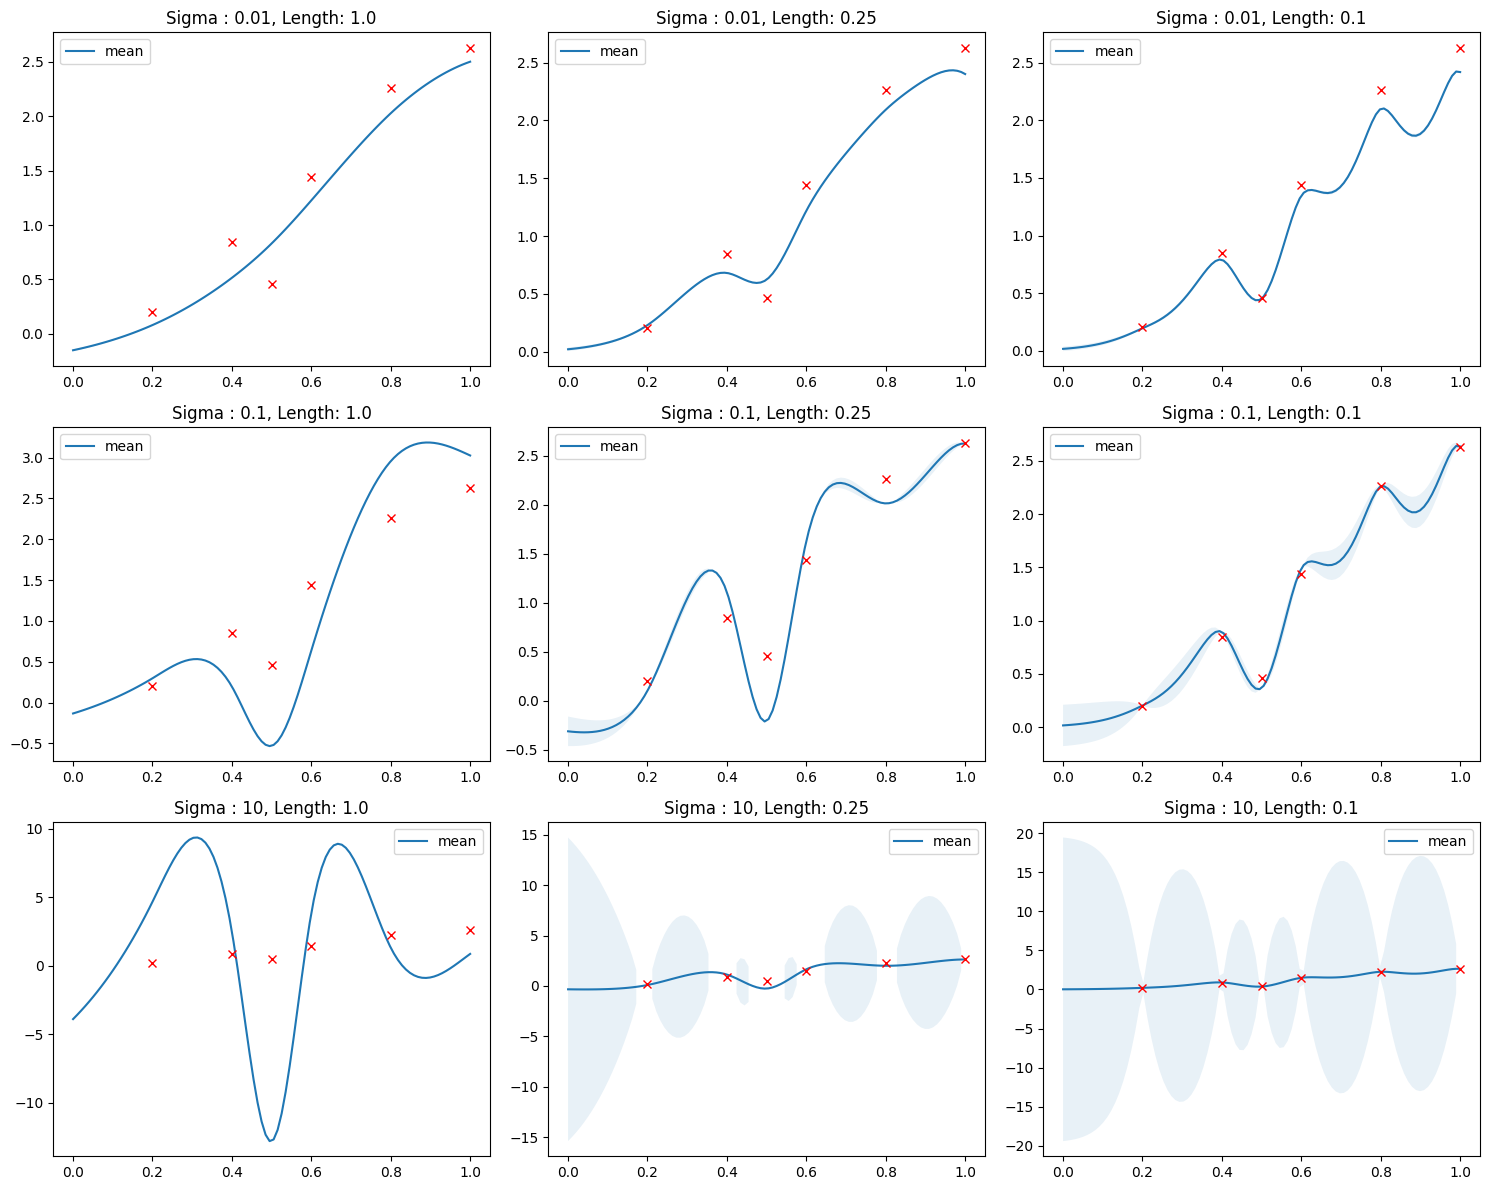

In [211]:
# 여러 length scale에 대해 GPR을 수행하고 결과를 시각화
length_scales = [1.0, 0.25, 0.1]
alpha = [0.01,0.1,10]
nu = [1.5, 2.5]

# 전체 플롯을 위한 figure 생성
fig, axs = plt.subplots(len(alpha), len(length_scales), figsize=(15, len(alpha) * 4))

for j in range(len(alpha)):
    for i, length_scale in enumerate(length_scales):
        # 커널 함수 적용
        K = matern_kernel(X_train, X_train, length_scale=length_scale, nu=nu[1], sigma_f=alpha[j])
        K_s = matern_kernel(X_train, X_test, length_scale=length_scale, sigma_f=alpha[j])
        K_ss = matern_kernel(X_test, X_test, length_scale=length_scale, sigma_f=alpha[j])
        K_inv = np.linalg.inv(K + 1e-5*np.eye(len(X_train)))  # 수치 안정성을 위해 작은 값 추가

        # 예측 수행
        mu_s = K_s.T.dot(K_inv).dot(y_train)
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

        # 서브플롯 설정
        ax = axs[j, i] if len(alpha) > 1 else axs[i]
        plt.sca(ax)
        plot_gp(mu_s, cov_s, X_test, X_train=X_train, y_train=y_train)
        plt.title(f'Sigma : {alpha[j]}, Length: {length_scale}')

plt.tight_layout()
plt.show()